### predictions on test data and on complete scan of patient #2:

In [1]:
# import libraries: 
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from PIL import Image
import imageio
import pickle
import re

In [2]:
# define metrics for model import: 
def diceCoef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def diceCoefLoss(y_true, y_pred):
    return (1-diceCoef(y_true, y_pred))

def jaccardDistance(y_true, y_pred, smooth=1):
    intersection = sum(abs(y_true * y_pred), axis=-1)
    sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1-jac) * smooth

def f1Score(y_true, y_pred):
    true_positives = sum(round(clip(y_true * y_pred, 0, 1)))
    possible_positives = sum(round(clip(y_true, 0, 1)))
    predicted_positives = sum(round(clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + epsilon())
    recall = true_positives / (possible_positives + epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+epsilon())
    return f1_val

In [4]:
# load saved model: 
model = load_model('/Users/krystanafoh/final_project_documentation/FINALmodel/model_best_128big_patients_2.h5', custom_objects={'diceCoefLoss': diceCoefLoss, 'diceCoef': diceCoef, 'jaccardDistance' : jaccardDistance, 'f1Score': f1Score})

#### import test data: 

In [6]:
data = np.load('./xytts_patients_128big/X_test_19_patients_128big.pkl', allow_pickle=True)

In [7]:
masks = np.load('./xytts_patients_128big/y_test_19_patients_128big.pkl', allow_pickle=True)

In [8]:
# predictions on test data: 
preds = model.predict(data)

In [10]:
# reshape to plot: 
temp = preds[130].reshape(128, 128)
tempX = data[130].reshape(128, 128)
tempy = masks[130].reshape(128,128)

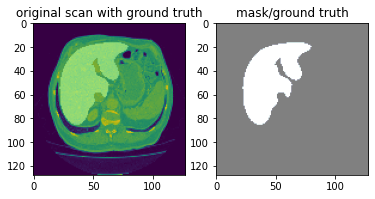

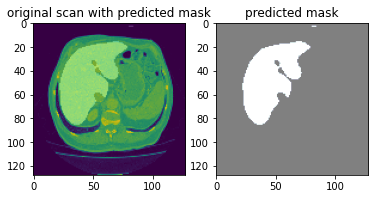

In [11]:
# plotting predicted masks examples in comparison to ground truth:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title('original scan with ground truth')
plt.imshow(tempX)
plt.imshow(tempy,cmap=plt.cm.bone, alpha=0.2 )

f.add_subplot(1,2, 2)
plt.title('mask/ground truth')
plt.imshow(tempy,cmap=plt.cm.bone, alpha=0.5 )

plt.show(block=True)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.title('original scan with predicted mask')
plt.imshow(tempX) 
plt.imshow(temp, cmap=plt.cm.bone, alpha=0.2) 

f.add_subplot(1,2, 2)
plt.title('predicted mask')
plt.imshow(temp, cmap=plt.cm.bone, alpha=0.5) 

plt.show(block=True)


#### predict on patient #2:

In [12]:
# load dataframe of patient 2: 
dfp2 = pd.read_pickle('./patient2.hdf') 

In [14]:
# only original scans: 
df_origp2 = dfp2['original']

In [17]:
# cut off suffix, to list: 
def cut_suffix(df):
    list_short = []
    for i in range(len(df)):
        short = df.iloc[i].rsplit('_', 1)[0]
        list_short.append(short)
    return list_short

In [18]:
list_shortp2 = cut_suffix(df_origp2)

In [19]:
# sort natural
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    ''' sorts in human order
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

list_shortp2.sort(key=natural_keys)

#### preprocessing for model input: 

In [21]:
# filepaths to arrays in list: 
def to_arrays(list):
    """reads in files from paths in df, converts them to pixel_arrays, returns list of pixel arrays"""
    im_list = []
    for i in list:
        ds = pydicom.read_file(i)
        data = ds.pixel_array
        im_list.append(data)
        
    return im_list

In [22]:
list_arrayp2 = to_arrays(list_shortp2)

In [23]:
# downsample all images in list: 
def downsampling(list):
    """downsamples images to 128*128 pixels. Returns list of images."""
    ds_img_list = []
    for array in list: 
        array = array[::4, ::4]
        ds_img_list.append(array)
        
    return ds_img_list

In [24]:
list_dsp2 = downsampling(list_arrayp2)

In [25]:
# to array of arrays: 
def to_array_array(list_of_arrays:list):
    """creates array of arrays, returns array."""
    array = np.asanyarray(list_of_arrays)
    return array

array_arrayp2 = to_array_array(list_dsp2)

In [26]:
# normalize: 
def normalize(array):
    """Normalize the array between -1000 and 400 (Hounsfield)"""
    min = -1000
    max = 400
    array[array < min] = min
    array[array > max] = max
    array = (array - min) / (max - min)  # hö
    array = array.astype("float32")
    return array                           # keras documentation

In [27]:
array_normp2 = normalize(array_arrayp2)

In [29]:
#reshape array: 
patient2 = array_normp2.reshape(172, 128, 128, -1)

#### predict on scans of patient 2: 

In [30]:
preds_p2 = model.predict(patient2)

#### get original masks as ground truths to plot in contrast: 


In [31]:
df_masksp2 = dfp2['mask']

#### preprocess: 

In [32]:
# cut off suffix, to list: 
def cut_suffix(df):
    list_short = []
    for i in range(len(df)):
        short = df.iloc[i].rsplit('_', 1)[0]
        list_short.append(short)
    return list_short

In [33]:
masks_p2 = cut_suffix(df_masksp2)

In [34]:
# sort natural
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    ''' sorts in human order
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

masks_p2.sort(key=natural_keys)

In [35]:
mask_arraysp2 = to_arrays(masks_p2)

In [36]:
mask_arraysp2 = downsampling(mask_arraysp2)

In [37]:
masks_arrayp2 = to_array_array(mask_arraysp2)

In [39]:
# reshape: 
masks_p2 = masks_arrayp2.reshape(172, 128, 128, -1)

#### plot example predictions on test data: 

In [55]:
# plot only downscaled original image: 
# reshape to plot: 
temppred = preds_p2[120].reshape(128, 128)
tempXp2 = patient2[120].reshape(128, 128)
tempyp2 = masks_p2[120].reshape(128,128)

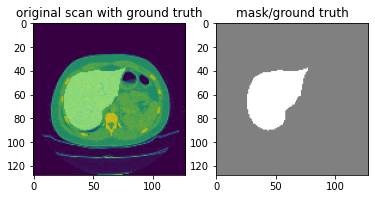

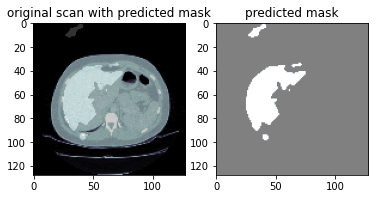

In [56]:
# plotting predicted masks examples in comparison to ground truth:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title('original scan with ground truth')
plt.imshow(tempXp2) 
plt.imshow(tempyp2,cmap=plt.cm.bone, alpha=0.2 )

f.add_subplot(1,2, 2)
plt.title('mask/ground truth')
plt.imshow(tempyp2,cmap=plt.cm.bone, alpha=0.5 )

plt.show(block=True)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.title('original scan with predicted mask')
plt.imshow(tempXp2,  cmap=plt.cm.bone)  
plt.imshow(temppred, cmap=plt.cm.bone, alpha=0.2) 

f.add_subplot(1,2, 2)
plt.title('predicted mask')
plt.imshow(temppred, cmap=plt.cm.bone, alpha=0.5) 

plt.show(block=True)

#### make gif of orginal scansd of patient 2 with predicted masks:

In [45]:
# merge scans and predicted masks: 
gif_pics_p2 = []

for i in range(len(patient2)):
               temppred = preds_p2[i].reshape(128, 128)
               tempXp2 = patient2[i].reshape(128, 128)
               pic = tempXp2  + temppred * 0.3
               gif_pics_p2.append(pic)               

In [48]:
# save merged images as png's: 
i = 1
lengths = []
for pic in gif_pics_p2:
    image = Image.fromarray(pic)
    name = f'{i}_picgif_neu.png'
    imsave(name , image)
    lengths.append(i)
    i += 1    

In [50]:
# create gif and save to disk: 
images = []
for i in range(1, 172):
    
    filename = f'./{i}_picgif_neu.png' #.format(i)
    images.append(imageio.imread(filename))

imageio.mimsave('animated_mask_patient_neu.gif', images, fps=20)